<h1> Attrition Model Building Project </h1>
<h2> Problem Statement </h2>
HRBP 로서 Attrition 관리의 중요성을 알고 퇴사하는 임직원에 대한 데이터를 검토 후 퇴사에 영향을 미치는 Factor 를 분석하여
퇴사확율을 구하여 해당 인력의 퇴사 가능성을 낮추는 데 분석의 목적이 있다.

## Dataset Load & EDA

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 데이터 불러오기
df = pd.read_excel("resources/ATTRITION DATA.xlsx")
df.head(2)

,e_code,status,hire_date,service_agreement,job_level,performance_rating_2018,performance_rating_2017,year_of_birth,gender,distance_from_home,...,potential_rating,bonus,no_courses_taken,time_in_position,awards,signon,manager_sat,employee_sat,salary_2017,salary_2018
0,45631,0,1990-09-17,N,3,4,3,1967,M,0.52,...,5,0,8,30,N,N,81,80,119968,124173
1,45632,0,1995-10-23,N,2,1,2,1971,M,0.08,...,5,2242,6,5,N,N,88,84,99330,100822


In [3]:
df.status.value_counts()

0    516
1    170
Name: status, dtype: int64

In [4]:
#import pandas_profiling
#profile = pandas_profiling.ProfileReport(df=df,minimal=True)
#profile.to_widgets()

## Feature Engineering

In [5]:
# Feature Engineering
df["var_rating"] = df["performance_rating_2018"] - df["performance_rating_2017"]
df["percentage_salary_change"] = (df["salary_2018"]-df["salary_2017"]) / df["salary_2017"] * 100
df["age"] = 2018-df["year_of_birth"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   e_code                    686 non-null    int64         
 1   status                    686 non-null    int64         
 2   hire_date                 686 non-null    datetime64[ns]
 3   service_agreement         686 non-null    object        
 4   job_level                 686 non-null    int64         
 5   performance_rating_2018   686 non-null    int64         
 6   performance_rating_2017   686 non-null    int64         
 7   year_of_birth             686 non-null    int64         
 8   gender                    686 non-null    object        
 9   distance_from_home        686 non-null    float64       
 10  manager_changes           686 non-null    int64         
 11  no_of_promotions          686 non-null    int64         
 12  risk_of_attrition     

In [6]:
# Variable Reduction
# 분석에 필요한 "변수 외 사용하지 않을 변수들에 대해서는 제거한다.
df = df.drop(columns=['year_of_birth',"performance_rating_2018","performance_rating_2017","salary_2017","salary_2018","hire_date","e_code"])

In [7]:
#변수 타입 변경
df = df.astype({"status" : "category","job_level" : "category","no_of_promotions" : "category","risk_of_attrition" : "category","potential_rating" : "category","var_rating":"category"})
df.dtypes

status                      category
service_agreement             object
job_level                   category
gender                        object
distance_from_home           float64
manager_changes                int64
no_of_promotions            category
risk_of_attrition           category
potential_rating            category
bonus                          int64
no_courses_taken               int64
time_in_position               int64
awards                        object
signon                        object
manager_sat                    int64
employee_sat                   int64
var_rating                  category
percentage_salary_change     float64
age                            int64
dtype: object

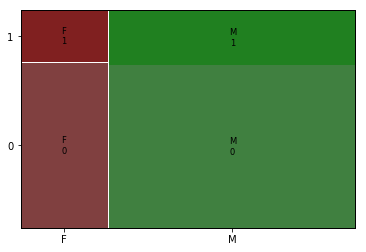

In [8]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(df,["gender","status"])
plt.show()

## 카이제곱 검정

In [9]:
def crosstab_multi (x,y) : 
    print (pd.crosstab(x,y),"\n\n",pd.crosstab(x,y,normalize="index"),"\n\n",pd.crosstab(x,y,normalize="columns"))

In [10]:
crosstab_multi (df["status"],df['gender'])

gender    F    M
status          
0       136  380
1        43  127 

 gender         F         M
status                    
0       0.263566  0.736434
1       0.252941  0.747059 

 gender         F         M
status                    
0       0.759777  0.749507
1       0.240223  0.250493


In [11]:
from scipy import stats

In [12]:
# 카이 제곱 검정을 빠르게 하도록 함수 설정
def chi_multi (x, y) :
    for i in x : #카이제곱 검정을 실시하여 p-Value 추출
        y = y
        table = pd.crosstab(df[ i ], y)
        chi_table = stats.chi2_contingency(table)
        if chi_table[1] > 0.005 :  #p-value 값이 귀무가설을 기각하는 지 검증하여 프린트
            pass
        else : 
            print ("귀무가설 기각 / p-value between",i ,"and", y.name," : ", chi_table[1])

In [13]:
chi_multi (list(df.columns.values), df["status"])

귀무가설 기각 / p-value between status and status  :  4.8361514559412625e-150
귀무가설 기각 / p-value between risk_of_attrition and status  :  3.944526151206098e-12
귀무가설 기각 / p-value between potential_rating and status  :  2.019545165087339e-05
귀무가설 기각 / p-value between no_courses_taken and status  :  3.911152449060662e-21
귀무가설 기각 / p-value between time_in_position and status  :  4.888814410957131e-05
귀무가설 기각 / p-value between awards and status  :  0.000875372103862832
귀무가설 기각 / p-value between manager_sat and status  :  3.8376510266153956e-63
귀무가설 기각 / p-value between employee_sat and status  :  2.053734365905802e-13
귀무가설 기각 / p-value between var_rating and status  :  0.0035318724704160947


## T-Test

In [14]:
ttest_result = pd.DataFrame()
stats.ttest_rel(df["manager_sat"],df['status'])[1]

0.0

## Variable Reduction

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   status                    686 non-null    category
 1   service_agreement         686 non-null    object  
 2   job_level                 686 non-null    category
 3   gender                    686 non-null    object  
 4   distance_from_home        686 non-null    float64 
 5   manager_changes           686 non-null    int64   
 6   no_of_promotions          686 non-null    category
 7   risk_of_attrition         686 non-null    category
 8   potential_rating          686 non-null    category
 9   bonus                     686 non-null    int64   
 10  no_courses_taken          686 non-null    int64   
 11  time_in_position          686 non-null    int64   
 12  awards                    686 non-null    object  
 13  signon                    686 non-null    object  

In [16]:
# p-value 가 낮은 값을 제거한다.
df = df.drop(columns=["gender","job_level","signon","age","manager_changes",'bonus','time_in_position'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   status                    686 non-null    category
 1   service_agreement         686 non-null    object  
 2   distance_from_home        686 non-null    float64 
 3   no_of_promotions          686 non-null    category
 4   risk_of_attrition         686 non-null    category
 5   potential_rating          686 non-null    category
 6   no_courses_taken          686 non-null    int64   
 7   awards                    686 non-null    object  
 8   manager_sat               686 non-null    int64   
 9   employee_sat              686 non-null    int64   
 10  var_rating                686 non-null    category
 11  percentage_salary_change  686 non-null    float64 
dtypes: category(5), float64(2), int64(3), object(2)
memory usage: 42.0+ KB


## Dummy variable creation

In [17]:
df = pd.get_dummies(df,drop_first=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   distance_from_home        686 non-null    float64
 1   no_courses_taken          686 non-null    int64  
 2   manager_sat               686 non-null    int64  
 3   employee_sat              686 non-null    int64  
 4   percentage_salary_change  686 non-null    float64
 5   status_1                  686 non-null    uint8  
 6   service_agreement_Y       686 non-null    uint8  
 7   no_of_promotions_1        686 non-null    uint8  
 8   no_of_promotions_2        686 non-null    uint8  
 9   no_of_promotions_3        686 non-null    uint8  
 10  no_of_promotions_4        686 non-null    uint8  
 11  no_of_promotions_5        686 non-null    uint8  
 12  no_of_promotions_6        686 non-null    uint8  
 13  no_of_promotions_7        686 non-null    uint8  
 14  no_of_prom

In [19]:
df = df.rename(columns={"var_rating_-1":"var_rating_minus_1"})
df = df.astype ({"status_1":"category"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   distance_from_home        686 non-null    float64 
 1   no_courses_taken          686 non-null    int64   
 2   manager_sat               686 non-null    int64   
 3   employee_sat              686 non-null    int64   
 4   percentage_salary_change  686 non-null    float64 
 5   status_1                  686 non-null    category
 6   service_agreement_Y       686 non-null    uint8   
 7   no_of_promotions_1        686 non-null    uint8   
 8   no_of_promotions_2        686 non-null    uint8   
 9   no_of_promotions_3        686 non-null    uint8   
 10  no_of_promotions_4        686 non-null    uint8   
 11  no_of_promotions_5        686 non-null    uint8   
 12  no_of_promotions_6        686 non-null    uint8   
 13  no_of_promotions_7        686 non-null    uint8   

## Modeling Data Preparation

In [20]:
from sklearn.model_selection import train_test_split

# x(독립변수) y(종속 변수) 분리
x_all = df.drop(columns = "status_1")
y_all = df["status_1"]

## 학습 및 p-Value 확인

In [21]:
# 학습 & p-value 확인
# 학습데이터로 학습을 진행하고, 각 독립변수에서 p-value값으로 유의미한 데이터를 찾아볼것이다.
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import statsmodels.api as sm

In [22]:
#stepwise regression 라이브러리에서 퍼옴
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    included = list(initial_list)
    while True:
        changed=False
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            if (len(included) == 0):
                model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            else:
                model = sm.OLS(y, pd.DataFrame(X[included + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        if not changed:
            break

    return included

In [42]:
#stepwise regression 라이브러리에서 퍼옴

def backward_regression(X, y,
                           threshold_out,
                           verbose=False):
    included=list(X.columns)
    while True:
        changed=False
        if (len(included) == 1):
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        else:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [58]:
forward_regression(x_all,y_all,threshold_in=0.05,verbose=True)

Add  manager_sat                    with p-value 1.26826e-24
Add  no_courses_taken               with p-value 1.69549e-14
Add  employee_sat                   with p-value 1.08825e-07
Add  distance_from_home             with p-value 5.44882e-06
Add  risk_of_attrition_2            with p-value 1.8289e-05
Add  awards_Y                       with p-value 0.000171431
Add  var_rating_0                   with p-value 0.000891434
Add  service_agreement_Y            with p-value 0.000755407
Add  potential_rating_5             with p-value 0.00145895
Add  risk_of_attrition_4            with p-value 0.00469944
Add  percentage_salary_change       with p-value 0.0117719
Add  var_rating_1                   with p-value 0.0085986
Add  var_rating_minus_1             with p-value 0.00102582


['manager_sat',
 'no_courses_taken',
 'employee_sat',
 'distance_from_home',
 'risk_of_attrition_2',
 'awards_Y',
 'var_rating_0',
 'service_agreement_Y',
 'potential_rating_5',
 'risk_of_attrition_4',
 'percentage_salary_change',
 'var_rating_1',
 'var_rating_minus_1']

## P-value 로 필터링 된 학습모델

In [59]:
# p-Value 가 높은 것들만 모아서 Model 화 함
x = df[['manager_sat',
 'no_courses_taken',
 'employee_sat',
 'distance_from_home',
 'risk_of_attrition_2',
 'awards_Y',
 'var_rating_0',
 'service_agreement_Y',
 'potential_rating_5',
 'risk_of_attrition_4',
 'percentage_salary_change',
 'var_rating_1',
 'var_rating_minus_1']]
y = df['status_1']

In [60]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size = 0.25, random_state = 0)
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))

514
172
514
172


In [61]:
logreg = LogisticRegression()
logreg.fit(x_train, y_train)

LogisticRegression()

In [62]:
y_pred = logreg.predict(x_test)
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

0.7965116279069767
              precision    recall  f1-score   support

           0       0.82      0.93      0.87       126
           1       0.69      0.43      0.53        46

    accuracy                           0.80       172
   macro avg       0.75      0.68      0.70       172
weighted avg       0.78      0.80      0.78       172



In [63]:
cnf_metrix = metrics.confusion_matrix(y_test, y_pred)
print (cnf_metrix)

[[117   9]
 [ 26  20]]


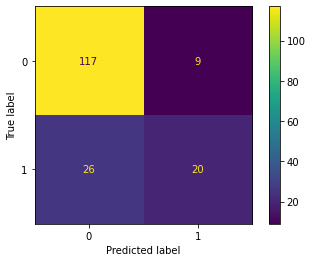

In [64]:
# heatmap 으로 보기
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, x_test, y_test)  # doctest: +SKIP
plt.show()

## P-value 로 필터를 하지 않은 학습모델

In [65]:
#p-value 정제하지 않고 모델링한 경우
x_all_train, x_all_test, y_all_train, y_all_test = train_test_split (x_all, y_all, test_size = 0.25, random_state = 0)
print(len(x_all_train))
print(len(x_all_test))
print(len(y_all_train))
print(len(y_all_test))

514
172
514
172


In [66]:
logreg_all = LogisticRegression()
logreg_all.fit(x_all_train, y_all_train)

LogisticRegression()

In [67]:
y_all_pred = logreg_all.predict(x_all_test)
print(metrics.accuracy_score(y_all_test, y_all_pred))
print(metrics.classification_report(y_all_test, y_all_pred))

0.7790697674418605
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       126
           1       0.67      0.35      0.46        46

    accuracy                           0.78       172
   macro avg       0.73      0.64      0.66       172
weighted avg       0.76      0.78      0.75       172



In [68]:
cnf_metrix_all = metrics.confusion_matrix(y_all_test, y_all_pred)
print (cnf_metrix_all)

[[118   8]
 [ 30  16]]


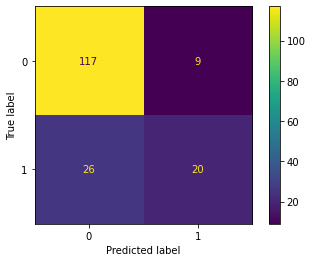

In [69]:
# heatmap 으로 보기
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logreg, x_test, y_test)  # doctest: +SKIP
plt.show()

## 학습모델 ROC Curve 그리기

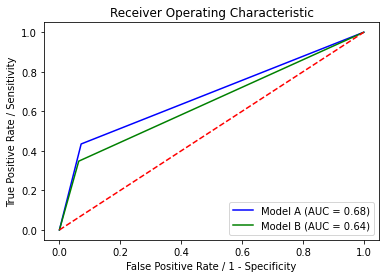

In [70]:
# Model A : p-value 고려 학습모델
# Model B : p-value 고려하지 않은 학습모델

from sklearn.metrics import roc_curve

fpr1, tpr1, threshold1 = metrics.roc_curve(y_test, y_pred)
fpr2, tpr2, threshold2 = metrics.roc_curve(y_all_test, y_all_pred)
roc_auc1 = metrics.auc(fpr1, tpr1)
roc_auc2 = metrics.auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr1, tpr1, 'blue', label = 'Model A (AUC = %0.2f)' % roc_auc1)
plt.plot(fpr2, tpr2, 'green', label = 'Model B (AUC = %0.2f)' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0,1],[0,1],"r--")
plt.xlim = [0,1]
plt.ylim = [0,1]
plt.ylabel('True Positive Rate / Sensitivity')
plt.xlabel('False Positive Rate / 1 - Specificity')
plt.show()